In [1]:
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import Audio,Image
from PIL import Image as PIL_Image
import multiprocessing
from joblib import Parallel,delayed

import os,sys
os.system("taskset -p 0xff %d" % os.getpid())
sys.path.append(os.path.expanduser('~')+'/audio_class/python')
sys.path.append('../../audio_class/python')
import audio_class
import ridgeDTW
import delay2loc

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DATAROOT = './BBSPjun5_13/'

In [3]:
########## Work on a single recording first
fs,data = audio_class.readSegment(DATAROOT+'day2-1370485107.wav')

In [4]:
print('fs = %s' % fs)
(nCh,nDat) = np.shape(data)
print('nCh = %s, nDat = %s' % (nCh,nDat))
Audio(data[0,:],rate=fs)

fs = 44100
nCh = 8, nDat = 2646000


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [52]:
# run ridge tracker on the data
def ridgePar(k,data,fs,btTime):
    S,F,T,tBlk,tInc = audio_class.spectrographic(data[k,:],fs,0.032,0.004)
    X = ridgeDTW.ridgeTracker(S,np.median(S.flatten()),btTime,tInc,isMaxPool=False,supThresh=4.)
    return T,F,X

btTime = 0.002
rvs = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(ridgePar)(k,data,fs,btTime) for k in range(nCh))

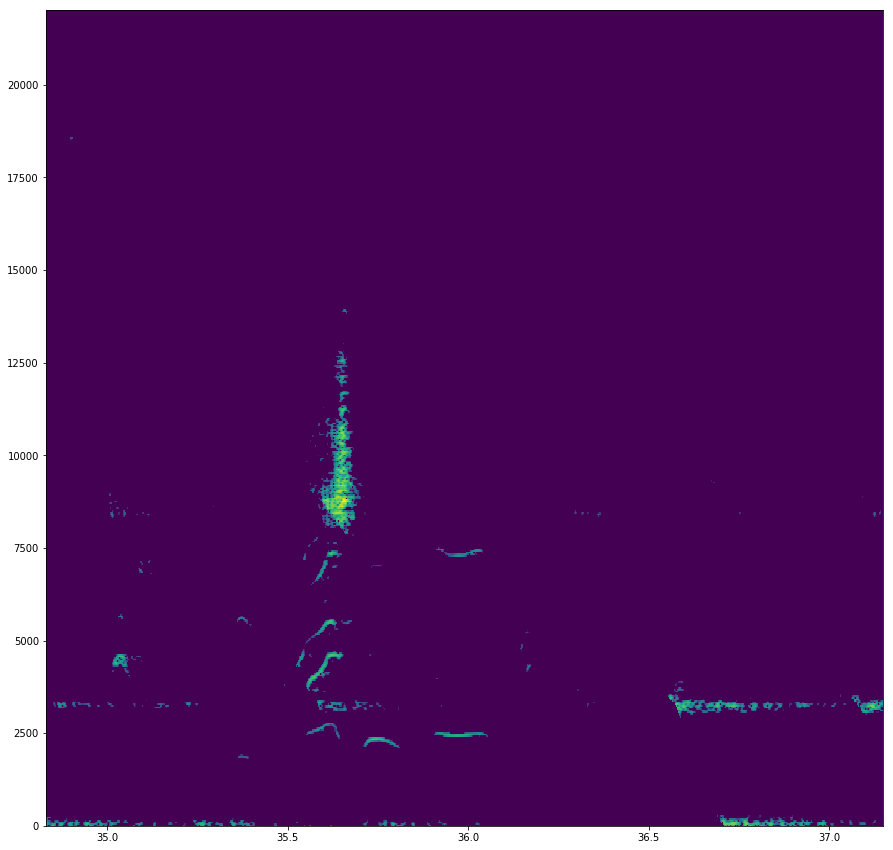

In [53]:
n1 = 12000
n2 = 12800
plt.figure(figsize=(15,15))
T,F,X = rvs[7]
plt.pcolormesh(T[n1:n2],F,np.sqrt(X[:,n1:n2]))

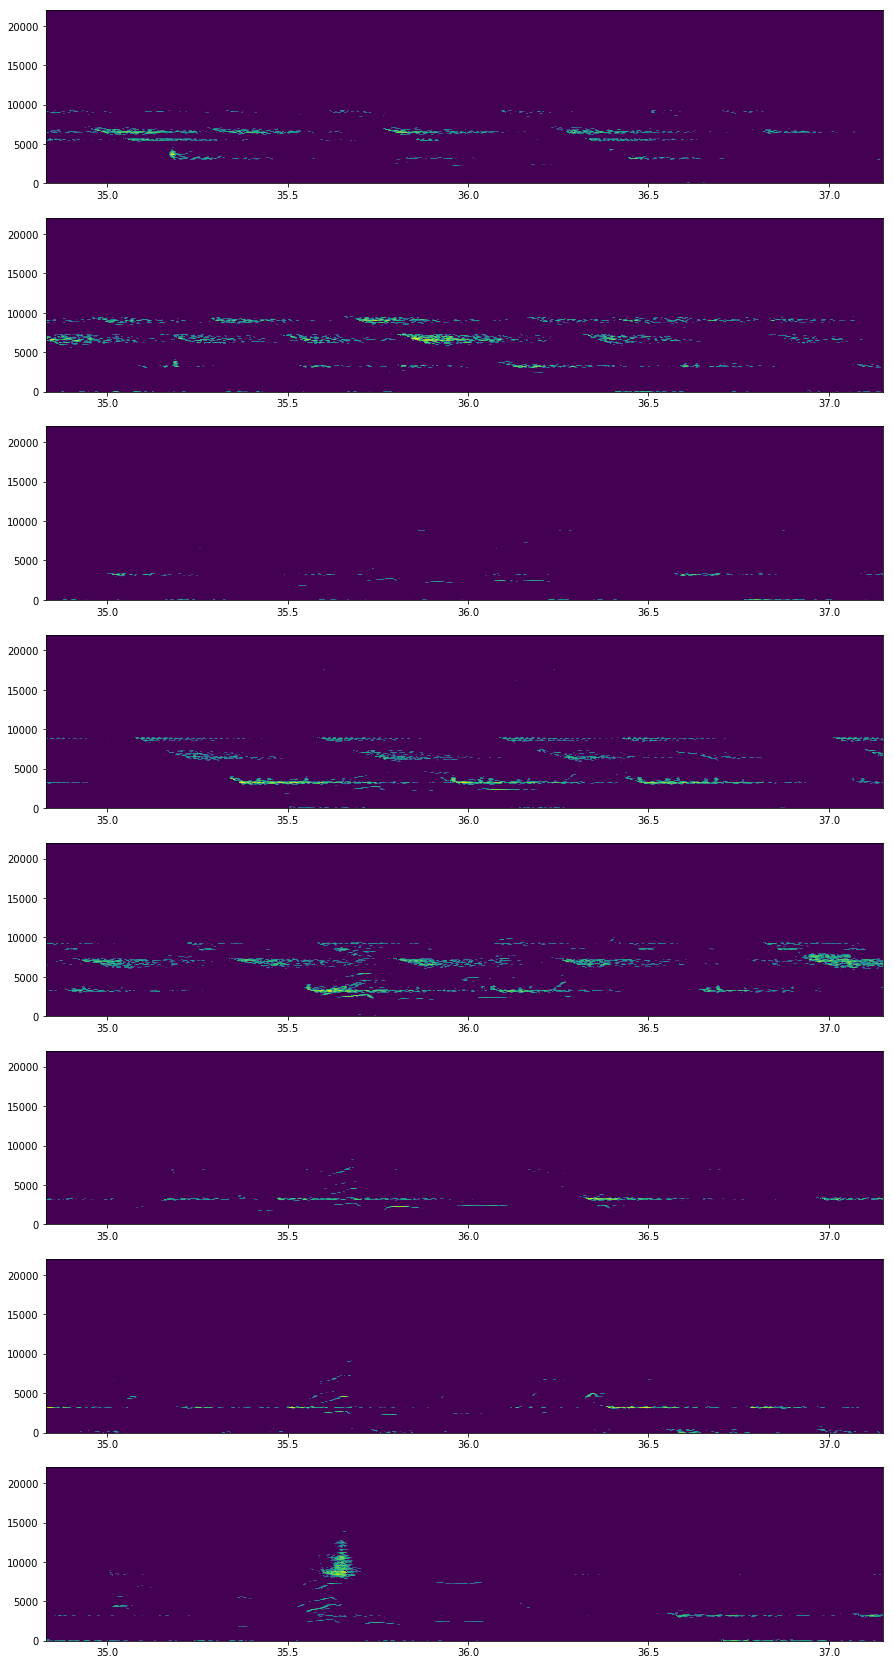

In [54]:
plt.figure(figsize=(15,30))
for k in range(nCh):
    plt.subplot(nCh,1,1+k)
    T,F,X = rvs[k]
    plt.pcolormesh(T[n1:n2],F,np.sqrt(X[:,n1:n2]))

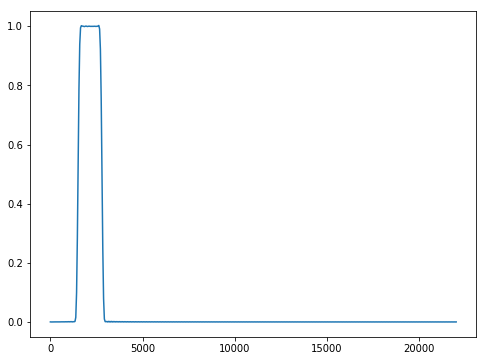

In [55]:
# filter design
h = sp.signal.firwin(len(F),[1500,2800],nyq = fs/2,pass_zero=False)
w,H = sp.signal.freqz(h)

plt.figure(figsize=(8,6))
plt.plot(w/np.pi*(fs/2),abs(H))

H = np.expand_dims(np.abs(H),axis=0)

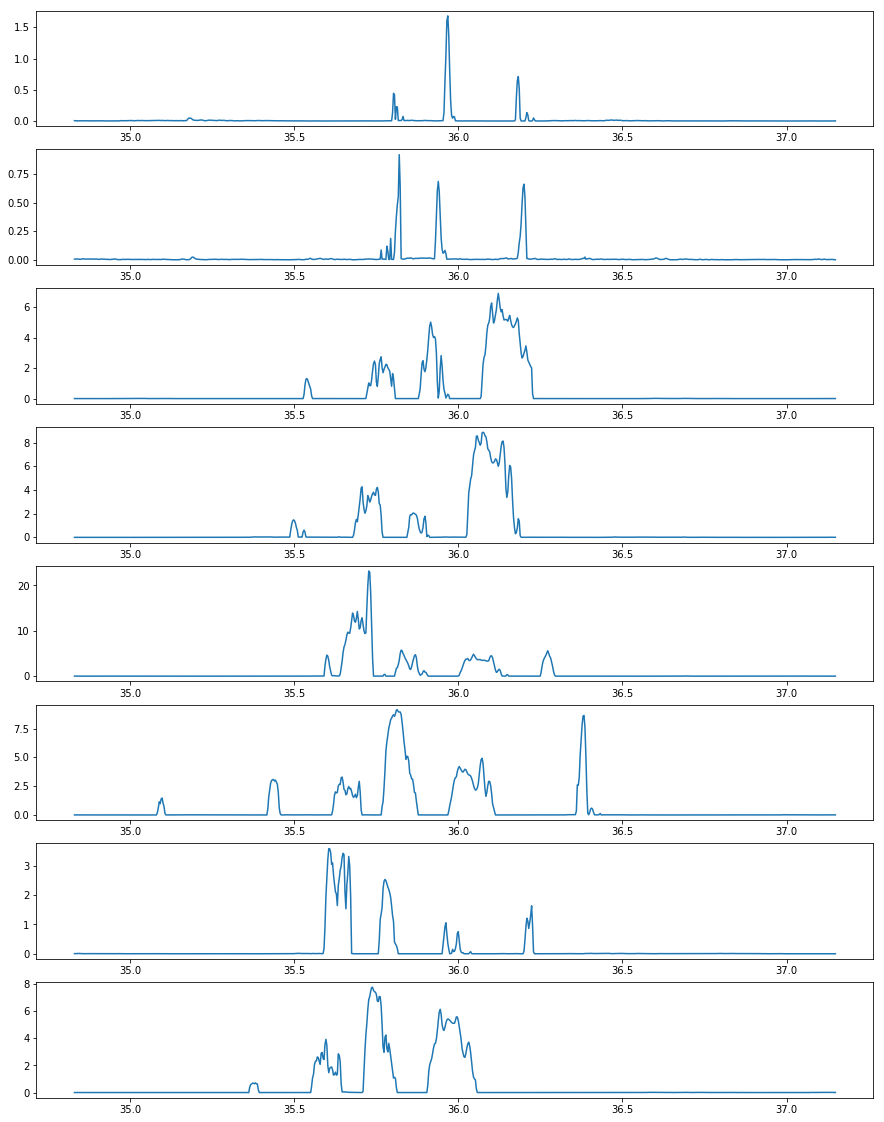

In [56]:
# triggers across mics for a clip
plt.figure(figsize=(15,20))
out = [None]*nCh
for k in range(nCh):
    plt.subplot(nCh,1,1+k)
    T,F,X = rvs[k]
    out[k] = np.squeeze(np.dot(H,X))
    plt.plot(T[n1:n2],out[k][n1:n2])

741


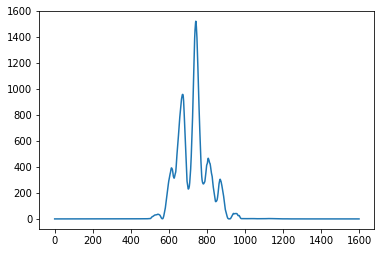

In [57]:
# sample correlation
corr = sp.signal.correlate(out[7][n1:n2],out[2][n1:n2])
print(np.argmax(corr))
plt.figure()
plt.plot(corr)
#print(T[0:5])
#print(np.diff(T[0:5]))

In [58]:
# measure the delays in matrix form
meas_delayMat = np.zeros((nCh,nCh))
mid = n2-n1
tDelta = T[1]-T[0]
print('tDelta = %s' % tDelta)
print('tBlk = %s' % (len(F)*2/fs))
for k in range(nCh):
    for l in range(k+1,nCh):
        meas_delayMat[k,l] = meas_delayMat[l,k] = \
            tDelta*(np.argmax(sp.signal.correlate(out[k][n1:n2],out[l][n1:n2]))-mid)

tDelta = 0.00290249433107
tBlk = 0.023219954648526078


In [59]:
print(meas_delayMat)

[[ 0.          0.14512472  0.0493424  -0.11319728  0.23800454  0.1538322
   0.3570068   0.22929705]
 [ 0.14512472  0.          0.02031746  0.06385488  0.08707483  0.12190476
   0.16544218  0.20027211]
 [ 0.0493424   0.02031746  0.          0.04063492  0.44117914  0.1015873
   0.49052154  0.16544218]
 [-0.11319728  0.06385488  0.04063492  0.          0.40054422  0.26702948
   0.46439909  0.11900227]
 [ 0.23800454  0.08707483  0.44117914  0.40054422  0.         -0.11900227
   0.05804989 -0.06095238]
 [ 0.1538322   0.12190476  0.1015873   0.26702948 -0.11900227  0.
   0.17705215  0.06095238]
 [ 0.3570068   0.16544218  0.49052154  0.46439909  0.05804989  0.17705215
   0.         -0.12770975]
 [ 0.22929705  0.20027211  0.16544218  0.11900227 -0.06095238  0.06095238
  -0.12770975  0.        ]]


In [60]:
# load mics' locations
micsloc = []
with open('micloc1.csv','r') as fid:
    for lines in fid:
        tokens = lines.split(',')
        micsloc.append([float(tokens[0]),float(tokens[1]),float(tokens[2])])
micsloc = np.array(micsloc)
print('micsloc = %s' % micsloc)

micsloc = [[-39.624   -3.048    3.048 ]
 [-30.48     0.       3.048 ]
 [-21.336    0.       0.9144]
 [-12.192   -3.048    0.9144]
 [ -3.048   -3.048    3.048 ]
 [  6.096    0.       3.048 ]
 [ 15.24    -3.048    0.9144]
 [ 24.384    0.       0.9144]]


In [61]:
# localize the source from the given delay measurement 
loc,err = delay2loc.delay2loc_grad(micsloc,meas_delayMat)

nIter = 1, |grad| = 4.42670845153e-05, err= 0.04551173063, mu = 1.0
nIter = 2, |grad| = 4.29940630847e-05, err= 0.0455086330177, mu = 1.0
nIter = 3, |grad| = 4.21717788085e-05, err= 0.045505572727, mu = 1.0
nIter = 4, |grad| = 4.18018075185e-05, err= 0.0455025391668, mu = 1.0
nIter = 5, |grad| = 4.18653122369e-05, err= 0.0454995207996, mu = 1.0
nIter = 6, |grad| = 4.23254147564e-05, err= 0.0454965054876, mu = 1.0
nIter = 7, |grad| = 4.31320146602e-05, err= 0.0454934808448, mu = 1.0
nIter = 8, |grad| = 4.42276802738e-05, err= 0.0454904345928, mu = 1.0
nIter = 9, |grad| = 4.55531706232e-05, err= 0.0454873549121, mu = 1.0
nIter = 10, |grad| = 4.70516579636e-05, err= 0.0454842307801, mu = 1.0
nIter = 11, |grad| = 4.86713774645e-05, err= 0.0454810522865, mu = 1.0
nIter = 12, |grad| = 5.03669015744e-05, err= 0.0454778109148, mu = 1.0
nIter = 13, |grad| = 5.2099435143e-05, err= 0.0454744997818, mu = 1.0
nIter = 14, |grad| = 5.38365281658e-05, err= 0.0454711138236, mu = 1.0
nIter = 15, |grad| 

In [ ]:
# generates 3D images of our environment
# refs: TRTimage.py from mpop
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h, 4 ) # quick reshape
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf
# refs: http://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
def draw_ball(axes,cen,rad):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = rad*np.cos(u)*np.sin(v)
    y = rad*np.sin(u)*np.sin(v)
    z = rad*np.cos(v)
    axes.plot_wireframe(cen[0]+x,cen[1]+y,cen[2]+z,color="r")

fig = plt.figure(figsize=(8,8))
axes = fig.gca(projection='3d')
#axes.set_aspect("equal")

axes.scatter(micsloc[:,0],micsloc[:,1],micsloc[:,2],s=100,c='b')
for k in range(nCh):
    axes.text(micsloc[k,0],micsloc[k,1],micsloc[k,2],'Mic %s' % k,
              fontweight='bold',fontsize='large')

axes.scatter(loc[0],loc[1],loc[2],c='r')
axes.text(loc[0],loc[1],loc[2],'Src',fontweight='bold',fontsize='large')

draw_ball(axes,loc,err*50)

axes.set_xlabel('X axis (m)')
axes.set_ylabel('Y axis (m)')
axes.set_zlabel('Z axis (m)')

images = []
for angle in range(0,360,1):
    axes.view_init(30, angle)
    imData = fig2data(fig)
    w,h,d = imData.shape
    im = PIL_Image.frombytes('RGBA',(w,h),imData)
    images.append(im)

(576, 576)
True
<PIL.Image.Image image mode=RGBA size=576x576 at 0x7F08F8121908>


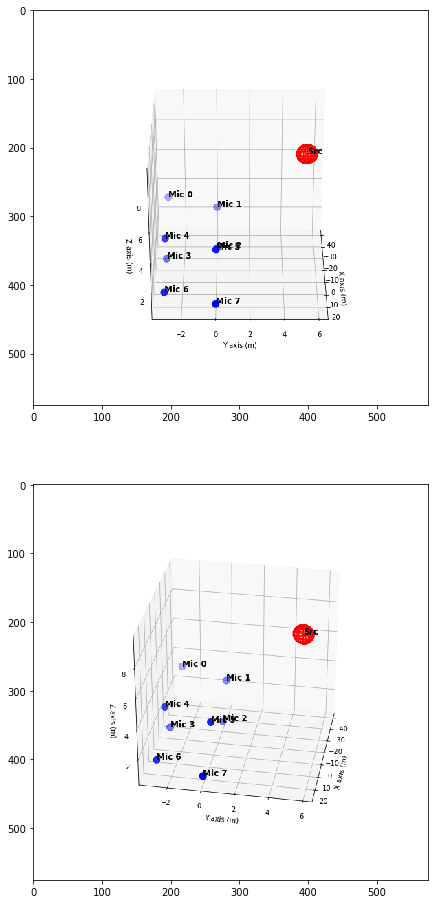

In [33]:
# sanity checks
size = fig.get_size_inches()*fig.dpi # size in pixels
size = tuple(size.astype(int))
print(size)
#print('(%s, %s)' % (w,h))
print(size == (w,h))

print(images[0])
plt.figure(figsize=(8,16))
plt.subplot(211)
plt.imshow(images[0])
plt.subplot(212)
plt.imshow(images[10])

In [34]:
# Animate
gif_pathname = 'images/micsloc_srcloc.gif'
gif = images[0]
gif.info['duration'] = tuple([100]*len(images)) # ms per frame
gif.info['loop'] = 0 # how many times to loop (0=infinite)
gif.save(fp=gif_pathname, format='gif', save_all=True, append_images=images[1:])

# verify that the number of frames in the gif equals the number of image files and durations
print(len(images))
print(PIL_Image.open(gif_pathname).n_frames == len(images))

# might need to refresh the page to reload the image,
# according to https://github.com/jupyter/notebook/issues/1369
Image(url=gif_pathname)

360
True


In [ ]:
########## Work on all recordings
for file in os.listdir(DATAROOT):
    print(file)
    fs,data = audio_class.readSegment(DATAROOT+file)
    break

0.011609977324263039
0.00290249433107
